# Modules

In [63]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, wilcoxon
from textwrap import wrap

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import calculate_pvalue, plot_coefs, plot_n_subjects, plot_significance
from pdathome.utils import key_value_list_to_dict

d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='ticks', rc=d_plot_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [44]:
step = 'gait'

# Load

In [45]:
with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', f'{step}_detection.json'), 'r') as f:
    d_performance = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'logreg.txt')) as f:
    coefs_logreg = f.read().split('\n')

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'rf.txt')) as f:
    coefs_rf = f.read().split('\n')

# Examine performance

## Feature coefficients

Logistic regression coefficients

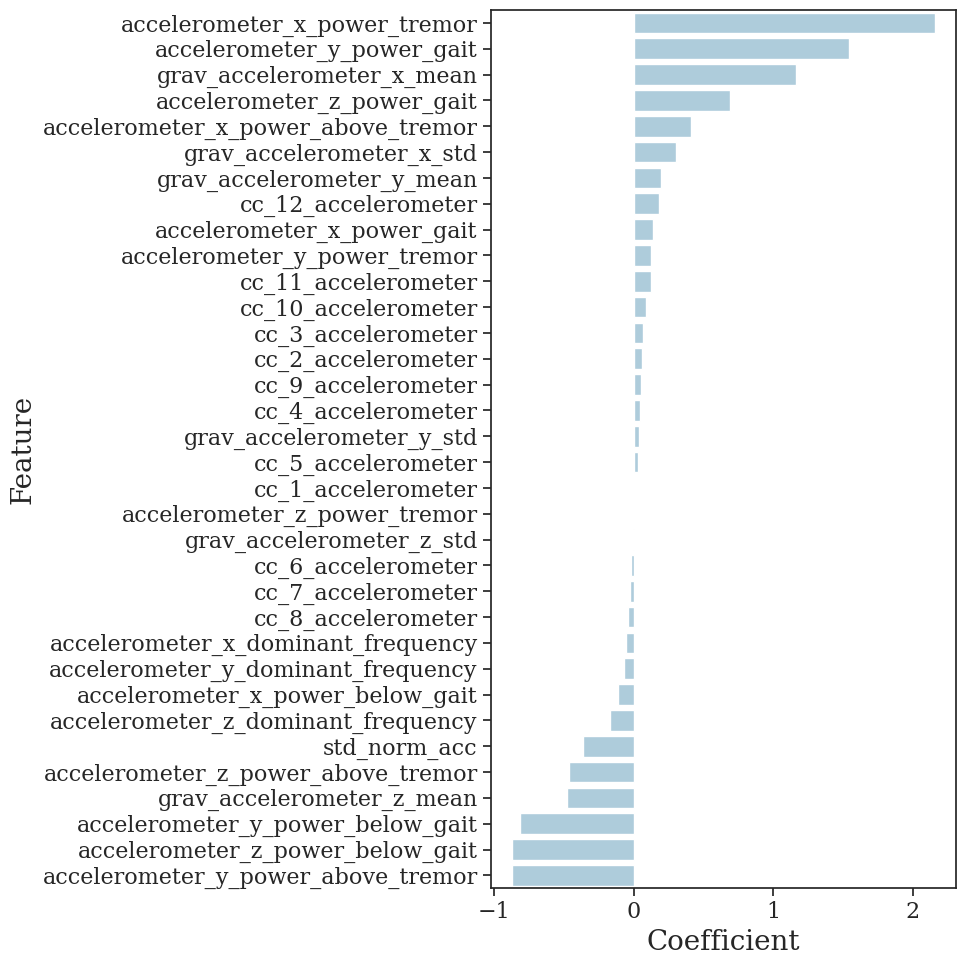

In [46]:
coefs_logreg = [x for x in coefs_logreg if len(x) > 0]
d_coefs_logreg = key_value_list_to_dict(coefs_logreg)
plot_coefs(d_coefs=d_coefs_logreg, classifier=gc.classifiers.LOGISTIC_REGRESSION, figsize=(10,10))

Random forest impurity scores

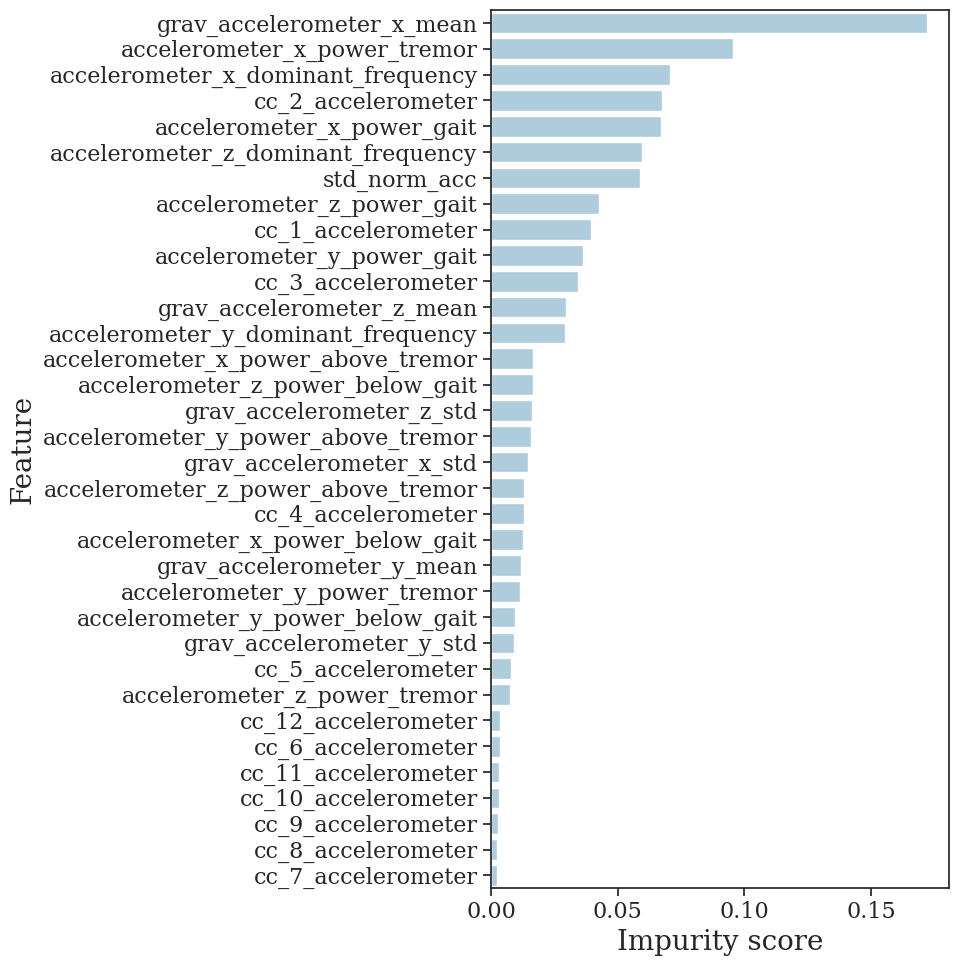

In [47]:
coefs_rf = [x for x in coefs_rf if len(x) > 0]
d_coefs_rf = key_value_list_to_dict(coefs_rf)
plot_coefs(d_coefs=d_coefs_rf, classifier=gc.classifiers.RANDOM_FOREST, figsize=(10,10))

## Dataset size

In [48]:
df_size = pd.DataFrame()

for (population, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.PRE_MED), (gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.POST_MED), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
    if population == gc.descriptives.PARKINSONS_DISEASE:
        l_ids = gc.participant_ids.L_PD_IDS
    else:
        l_ids = gc.participant_ids.L_HC_IDS

    for subject in l_ids:
        for segment_duration in d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['segment_duration'].keys():
            segment_duration_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['segment_duration'][segment_duration]['minutes']

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                'gait',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['gait', 'non_gait']:

            total_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)


df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Activity', 'Segment duration', 'Mean (SD) number of minutes']

df_size_grouped.set_index(['Population', 'Activity', 'Segment duration'])

Mean (SD) number of minutes
Population Activity Segment duration                            
PD pre     gait     short                            0.87 (0.45)
                    moderately_long                   1.78 (0.8)
                    long                             1.91 (0.87)
                    very_long                        9.17 (5.67)
                    total                           13.73 (5.81)
           non_gait total                          78.33 (15.18)
PD post    gait     short                            0.54 (0.32)
                    moderately_long                  1.22 (0.52)
                    long                              1.1 (0.65)
                    very_long                        8.63 (5.39)
                    total                            11.4 (5.65)
           non_gait total                          45.89 (16.26)
HC         gait     short                             1.7 (0.64)
                    moderately_long                  2.29 (0.76)
                    long                             1.76 (1.38)
                    very_long                       14.32 (5.53)
                    total                           20.07 (6.56)
           non_gait total                          74.74 (15.55)

## General performance
Split by population (PD, HC) and medication state for PD (pre-med, post-med)

In [49]:
df_performance = pd.DataFrame()

for gd_model in [gc.classifiers.LOGISTIC_REGRESSION, gc.classifiers.RANDOM_FOREST]:
    for (pop, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, 'pre'), (gc.descriptives.PARKINSONS_DISEASE, 'post'), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
        if pop == gc.descriptives.PARKINSONS_DISEASE:
            l_subjects = gc.participant_ids.L_PD_IDS
            pop_medstage = f"{pop}_{med_stage}"
        else:
            l_subjects = gc.participant_ids.L_HC_IDS
            pop_medstage = pop

        sens = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] for x in l_subjects]
        spec = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'] for x in l_subjects]
        bacc = [(x+y)/2 for x,y in zip(sens, spec)]
        auc = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['auc'] for x in l_subjects]

        df_performance = pd.concat([df_performance, pd.DataFrame([gd_model,
                                                                  pop_medstage,
                                                                  f"{np.round(np.mean(bacc),2)} ({np.round(np.std(bacc),2)})",
                                                                  f"{np.round(np.mean(sens),2)} ({np.round(np.std(sens),2)})",
                                                                  f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                                                  f"{np.round(np.mean(auc),2)} ({np.round(np.std(auc),2)})"
                                                                 ]).T], axis=0).reset_index(drop=True)
        
            
df_performance.columns = ['Classifier', 'Population', 'Balanced accuracy', 'Sensitivity', 'Specificity', 'AUC']

for med_stage in ['pre', 'post']:
    rf_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]
    logreg_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]

    print(f"*PD {med_stage}-med* random forest vs. logistic regression balanced accuracy: p = {wilcoxon(rf_bacc, logreg_bacc)[1]}")

df_performance.pivot(index='Population', columns='Classifier', values=['Sensitivity', 'Specificity', 'AUC']).sort_index(ascending=False)

*PD pre-med* random forest vs. logistic regression balanced accuracy: p = 6.532669067382812e-05
*PD post-med* random forest vs. logistic regression balanced accuracy: p = 0.0008091926574707031


Sensitivity               Specificity                       AUC  \
Classifier       logreg           rf       logreg           rf       logreg   
Population                                                                    
PD_pre      0.83 (0.09)  0.88 (0.09)  0.96 (0.02)  0.95 (0.03)  0.98 (0.02)   
PD_post     0.88 (0.08)  0.94 (0.05)  0.94 (0.04)  0.92 (0.05)  0.98 (0.01)   
HC          0.91 (0.04)  0.96 (0.02)  0.88 (0.07)  0.83 (0.09)  0.97 (0.01)   

                         
Classifier           rf  
Population               
PD_pre      0.98 (0.01)  
PD_post     0.99 (0.01)  
HC          0.98 (0.01)

## Effect of behavior

Effect of activities on the specificity of the classifier

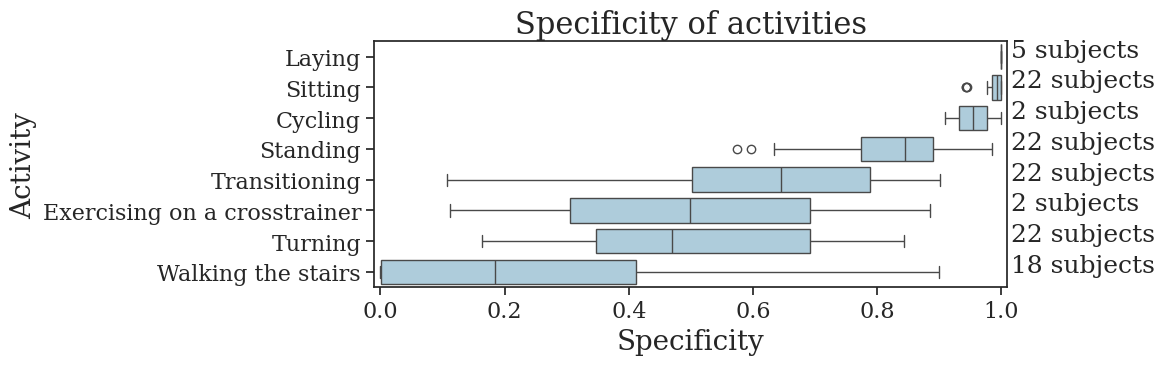

In [50]:
l_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'].keys()) for x in gc.participant_ids.L_PD_IDS] for x in y if x != 'Walking']))

d_activity_performance = {}

for activity in l_activities:
    d_activity_performance[activity] = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'][activity]['spec'] for x in gc.participant_ids.L_PD_IDS if activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities']]

    # print(f"{activity}: {np.round(np.mean(d_activity_performance[activity]),2)} +/- {np.round(np.std(d_activity_performance[activity]),2)}")

d_activity_performance = {k: v for k, v in sorted(d_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

fig, ax = plt.subplots(figsize=(12, 4))

sns.boxplot(data=d_activity_performance, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')

plot_n_subjects(d_performance=d_activity_performance, x_loc=1.015, ax=ax)

ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Specificity')
ax.set_ylabel('Activity')
ax.set_title('Specificity of activities')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Effect of arm activities during gait on the sensitivity of the classifier

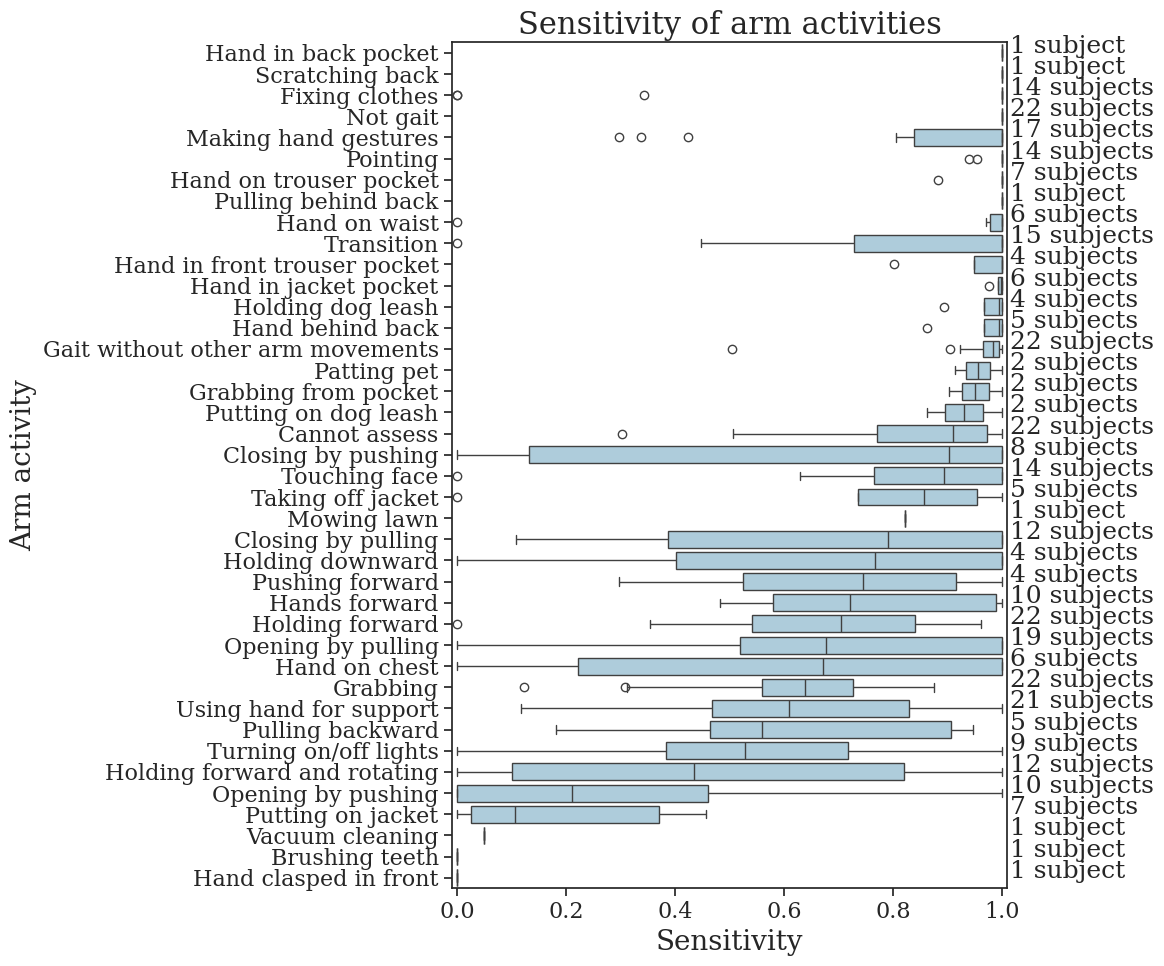

In [51]:
l_arm_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'].keys()) for x in gc.participant_ids.L_PD_IDS] for x in y]))

d_arm_activity_performance = {}

for arm_activity in l_arm_activities:
    d_arm_activity_performance[arm_activity] = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'][arm_activity]['sens'] for x in gc.participant_ids.L_PD_IDS if arm_activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities']]

d_arm_activity_performance = {k: v for k, v in sorted(d_arm_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(data=d_arm_activity_performance, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')

plot_n_subjects(d_performance=d_arm_activity_performance, x_loc=1.015, ax=ax)

ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Sensitivity')
ax.set_ylabel('Arm activity')
ax.set_title('Sensitivity of arm activities')

plt.tight_layout()
plt.show()

Effect of gait sequence duration on the sensitivity of the classifier

In [54]:
d_segment_performance

{1: [], 2: [], 3: [], 4: []}

Sensitivity per segment duration
short: 0.63 +/- 0.19
moderately_long: 0.81 +/- 0.12
long: 0.76 +/- 0.19
very_long: 0.94 +/- 0.14


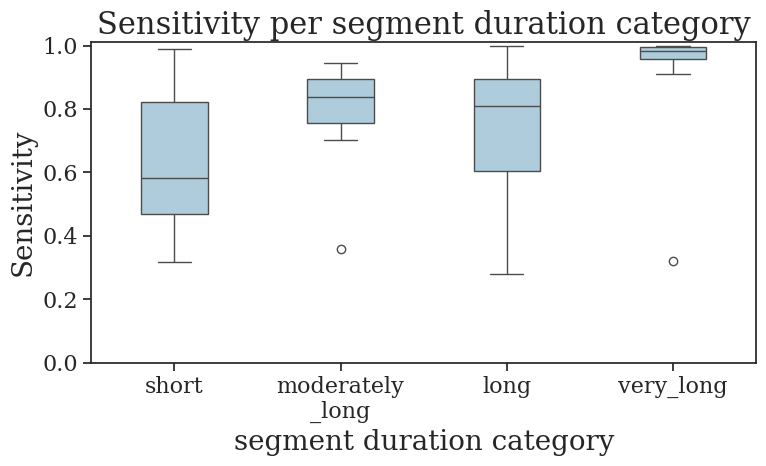

In [57]:
l_segment_durations = list(mp.segment_map.values())
new_xtick_labels = ['\n'.join(wrap(x,10)) for x in l_segment_durations]

d_segment_performance = {}

print("Sensitivity per segment duration")
for segment_duration in l_segment_durations:
    d_segment_performance[segment_duration] = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
        [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
        [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
        ['segment_duration'][segment_duration]['sens']
        for x in gc.participant_ids.L_PD_IDS 
        if segment_duration in (
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
            ['segment_duration'].keys()
        )
    ]

    print(f"{segment_duration}: {np.round(np.mean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.std(d_segment_performance[segment_duration]),2)}")

# d_segment_performance = {k: v for k, v in sorted(d_segment_performance.items(), key=lambda item: np.median(item[1]), reverse=False)}

fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

ax.set_ylabel('Sensitivity')
ax.set_xlabel('segment duration category')
ax.set_title('Sensitivity per segment duration category')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)
ax.set_ylim([0, 1.01])

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sensitivity per Segment duration
short: 0.63 +/- 0.19
moderately_long: 0.81 +/- 0.12
long: 0.76 +/- 0.19
very_long: 0.94 +/- 0.14


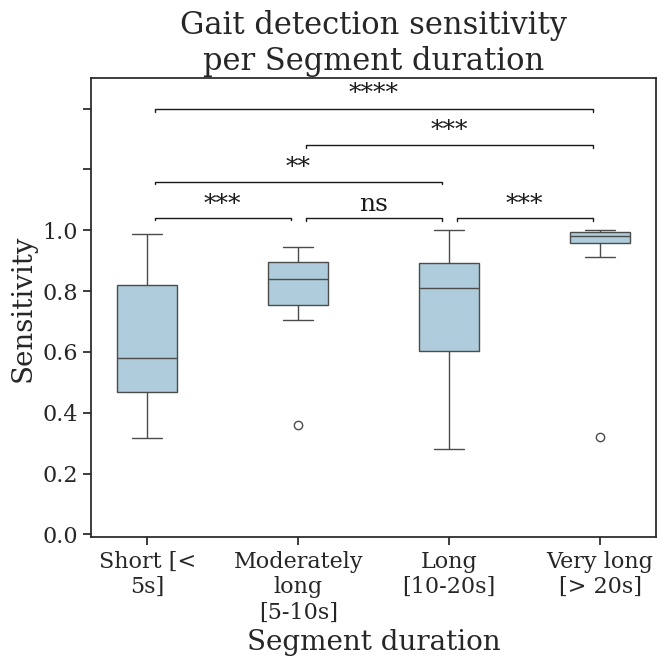

In [68]:
l_segment_durations = list(mp.segment_map.values())
new_xtick_labels = ['\n'.join(wrap(mp.segment_rename[x],10)) for x in l_segment_durations]

d_segment_performance = {}

d_segment_classes = {
    '0': 'short',
    '1': 'moderately_long',
    '2': 'long',
    '3': 'very_long',
}

d_comparisons_per_row = {
    '1': [[0, 1], [1, 2], [2, 3]],
    '2': [[0, 2]],
    '3': [[1, 3]],
    '4': [[0, 3]]
}

print("Sensitivity per Segment duration")
for segment_duration in l_segment_durations:
    d_segment_performance[segment_duration] = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
        [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
        [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
        ['segment_duration'][segment_duration]['sens'] 
        for x in gc.participant_ids.L_PD_IDS 
        if segment_duration in (
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
            ['segment_duration'].keys()
        )
    ]

    print(f"{segment_duration}: {np.round(np.mean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.std(d_segment_performance[segment_duration]),2)}")

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

for row, comparisons in d_comparisons_per_row.items():
    for comparison in comparisons:
        vals_1 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['segment_duration'][d_segment_classes[str(comparison[0])]]['sens'] for x in gc.participant_ids.L_PD_IDS]
        vals_2 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['segment_duration'][d_segment_classes[str(comparison[1])]]['sens'] for x in gc.participant_ids.L_PD_IDS]
        pvalue = calculate_pvalue(vals_1, vals_2, 'wilcoxon')[1]
        plot_significance(ax, comparison[0]+0.05, comparison[1]-0.05, pvalue, 1, 0.12, int(row), d_plot_params['font.size'])


ax.set_ylim([-0.01, 1.5])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Segment duration')
ax.set_title('Gait detection sensitivity\nper Segment duration')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)

for i in range(1,4):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Effect of gait sequence duration on differences between PD pre-med and post-med in sensitivity of the classifier

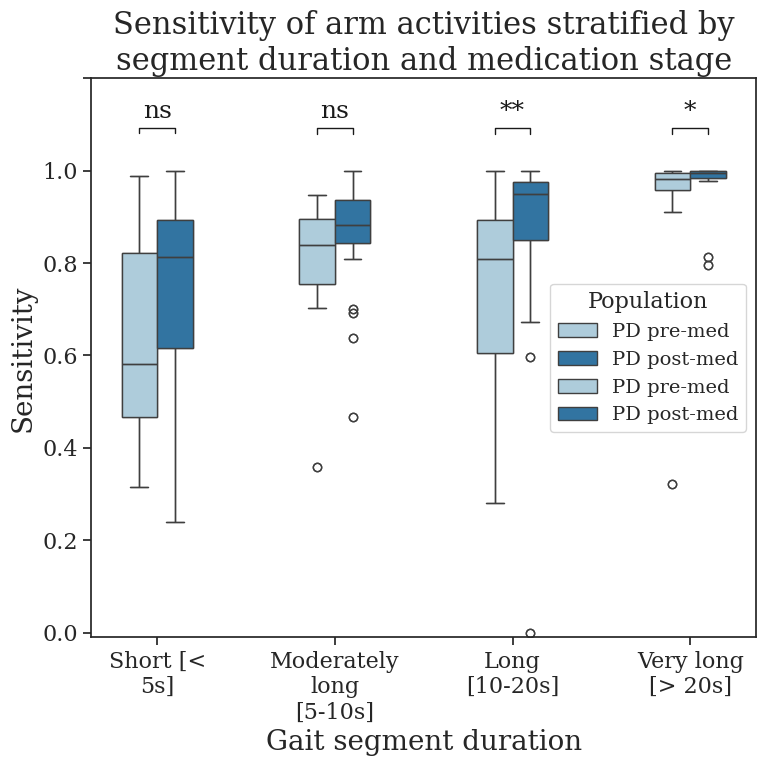

In [71]:
l_segment_durations = list(mp.segment_rename.keys())
new_xtick_labels = ['\n'.join(wrap(mp.segment_rename[x],10)) for x in l_segment_durations]

d_stages = {
    '0': 'PD pre-med', 
    '1': 'PD post-med', 
    '2': 'Conrols',
}

d_comparisons_per_row = {
    '1': [[0, 1], [1, 2]],
    '2': [[0, 2]]
}


df_seq = pd.DataFrame()
for segment_duration in l_segment_durations:
    for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
        d_seq_performance = [
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][med_stage]
            ['segment_duration'][segment_duration]['sens'] 
            for x in gc.participant_ids.L_PD_IDS 
            if segment_duration in (
                d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
                [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
                [gc.descriptives.MOST_AFFECTED_SIDE][med_stage]
                ['segment_duration'].keys()
            )
        ]
        
        med_stage_label = f'PD {med_stage}-med'
        df_seq = pd.concat([
            df_seq,
            pd.DataFrame([
                d_seq_performance,
                np.repeat(segment_duration, len(d_seq_performance)),
                np.repeat(med_stage_label, len(d_seq_performance))], index=['sens', 'segment_duration', 'med_stage']
                ).T])
        
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=df_seq, x='segment_duration', y='sens', hue='med_stage', width=0.4, ax=ax, palette='Paired')

sns.boxplot(data=df_seq, x='segment_duration', y='sens', hue='med_stage', width=0.4, ax=ax, palette='Paired')

for j, segment_duration in enumerate(l_segment_durations):
    l_valid_pd_ids = [x for x in gc.participant_ids.L_PD_IDS if segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['segment_duration'].keys() and segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['segment_duration'].keys()]

    vals_pre = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['segment_duration'][segment_duration]['sens'] for x in l_valid_pd_ids]
    vals_post = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['segment_duration'][segment_duration]['sens'] for x in l_valid_pd_ids]
    
    pvalue = calculate_pvalue(vals_pre, vals_post, 'wilcoxon')[1]
    plot_significance(ax, j-0.1, j+0.1, pvalue, 1.05, 0.09, 1, d_plot_params['font.size'])

ax.set_ylim([-0.01, 1.2])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Gait segment duration')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)
ax.set_title('Sensitivity of arm activities stratified by\nsegment duration and medication stage')
ax.legend(title='Population')

for i in range(1,2):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PD pre-med vs post-med after correcting for sequence duration and arm activities

System: specific - p-value: 4.1961669921875e-05
System: overall - p-value: 0.3369474411010742


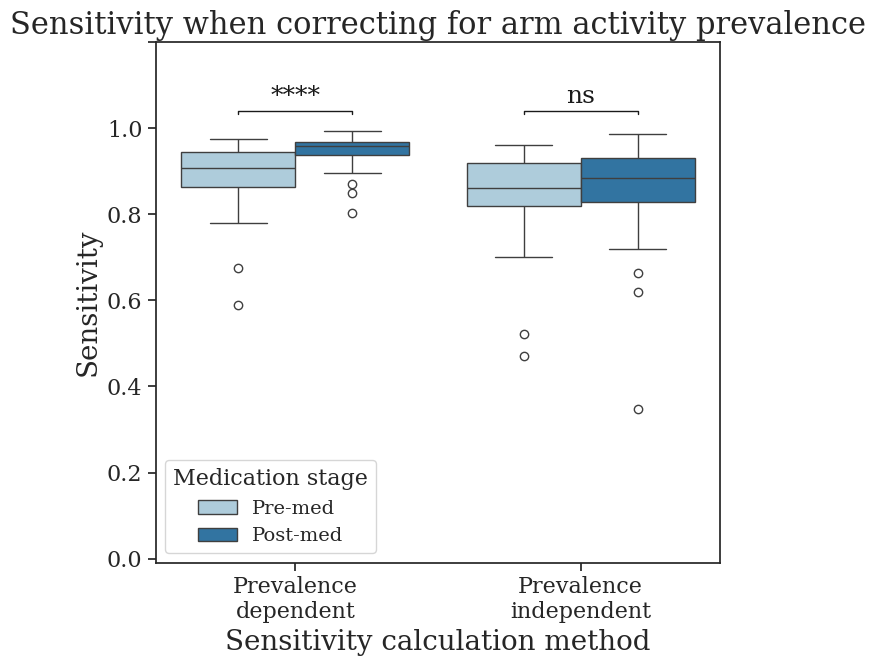

In [72]:
df_arm_activity = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for segment_duration in mp.segment_rename.keys():
            try:
                d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['segment_duration'][segment_duration]
            except KeyError:
                continue
            else:
                for arm_activity in d_focus['arm_activities'].keys():
                    mins = d_focus['arm_activities'][arm_activity]['mins']
                    sens = d_focus['arm_activities'][arm_activity]['sens']
                    df_arm_activity = pd.concat([df_arm_activity, pd.DataFrame([mins, sens, segment_duration, arm_activity, subject, med_stage], index=['mins', 'sens', 'segment_duration', gc.columns.ARM_LABEL, gc.columns.ID, gc.columns.PRE_OR_POST]).T])

df_prev_overall = df_arm_activity.groupby([gc.columns.ID, gc.columns.ARM_LABEL, 'segment_duration'])['mins'].sum() / df_arm_activity.groupby(gc.columns.ID)['mins'].sum()
df_prev_specific = df_arm_activity.groupby([gc.columns.ID, gc.columns.PRE_OR_POST, gc.columns.ARM_LABEL, 'segment_duration'])['mins'].sum() / df_arm_activity.groupby([gc.columns.ID, gc.columns.PRE_OR_POST])['mins'].sum()

df_arm_activity = pd.merge(left=df_arm_activity, right=df_prev_specific, suffixes=['', '_specific'], how='left', on=[gc.columns.PRE_OR_POST, gc.columns.ID, gc.columns.ARM_LABEL, 'segment_duration'])
df_arm_activity = pd.merge(left=df_arm_activity, right=df_prev_overall, suffixes=['', '_overall'], how='left', on=[gc.columns.ID, gc.columns.ARM_LABEL, 'segment_duration'])

df_arm_activity = df_arm_activity.rename(columns={x: x.replace('mins_', 'prop_') for x in df_arm_activity.columns})

df_sens_prevalence = pd.DataFrame()

for stage in ['pre', 'post']:
    df_stage = df_arm_activity.loc[df_arm_activity[gc.columns.PRE_OR_POST]==stage]
    for subject in gc.participant_ids.L_PD_IDS:
        df_subject = df_stage.loc[df_stage[gc.columns.ID]==subject]
        if df_subject.shape[0] > 0:

            for system in ['specific', 'overall']:
                sens = np.sum(np.multiply(df_subject['sens'], df_subject[f'prop_{system}']))

                df_sens_prevalence = pd.concat([df_sens_prevalence, pd.DataFrame([stage, subject, system, sens]).T])

df_sens_prevalence.columns = [gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens']

l_drop_ids = [x for x in df_sens_prevalence.loc[df_sens_prevalence[gc.columns.PRE_OR_POST]=='pre', gc.columns.ID].unique() if x not in df_sens_prevalence.loc[df_sens_prevalence[gc.columns.PRE_OR_POST]=='post', gc.columns.ID].unique()]
df_sens_prevalence = df_sens_prevalence.loc[~df_sens_prevalence[gc.columns.ID].isin(l_drop_ids)]

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=df_sens_prevalence, x='system', y='sens', hue=gc.columns.PRE_OR_POST, order=['specific', 'overall'], palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(['specific', 'overall']):
    vals_1 = list(df_sens_prevalence.loc[(df_sens_prevalence['system']==system) & (df_sens_prevalence[gc.columns.PRE_OR_POST]=='pre'), 'sens'].values)
    vals_2 = list(df_sens_prevalence.loc[(df_sens_prevalence['system']==system) & (df_sens_prevalence[gc.columns.PRE_OR_POST]=='post'), 'sens'].values)

    pvalue = calculate_pvalue(vals_1, vals_2, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j+0.2, x_max=j-0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([-0.01,1.2])
ax.set_xticks(ax.get_xticks(), ['Prevalence\ndependent', 'Prevalence\nindependent'])

ax.set_title('Sensitivity when correcting for arm activity prevalence')
ax.set_xlabel('Sensitivity calculation method')
ax.set_ylabel('Sensitivity')

ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['Pre-med', 'Post-med'], title='Medication stage')

for j in range(1,2):
    ax.yaxis.get_major_ticks()[-1*j].label1.set_visible(False)

fig.tight_layout()
 
plt.show()

## Effect of PD

Correlation with MDS-UPDRS

In [75]:
d_performance['PD']['hbv002'].keys()

dict_keys(['logreg', 'rf'])

In [73]:
df_seq_subscore = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    subscore = d_performance['PD'][subject]['clinical']['pre']['MAS']['subscore']
    for seq_duration in d_performance['PD'][subject]['rf']['MAS']['pre']['seq_duration'].keys():
        sens = d_performance['PD'][subject]['rf']['MAS']['pre']['seq_duration'][seq_duration]['sens']
        df_seq_subscore = pd.concat([df_seq_subscore, pd.DataFrame([subscore, seq_duration, sens, subject], index=['subscore', 'seq_duration', 'sens', 'id']).T])

df_seq_subscore['subscore'] = df_seq_subscore['subscore'].astype(int)
df_seq_subscore['sens'] = df_seq_subscore['sens'].astype(float)

KeyError: 'clinical'

Spearman correlation between subscore and sensitivity for ...

... Short [<5s] segments: 0.18 (p=0.42)
... Moderately long [5-10s] segments: -0.29 (p=0.19)
... Long [10-20s] segments: 0.23 (p=0.31)
... Very long [>20s] segments: -0.13 (p=0.57)


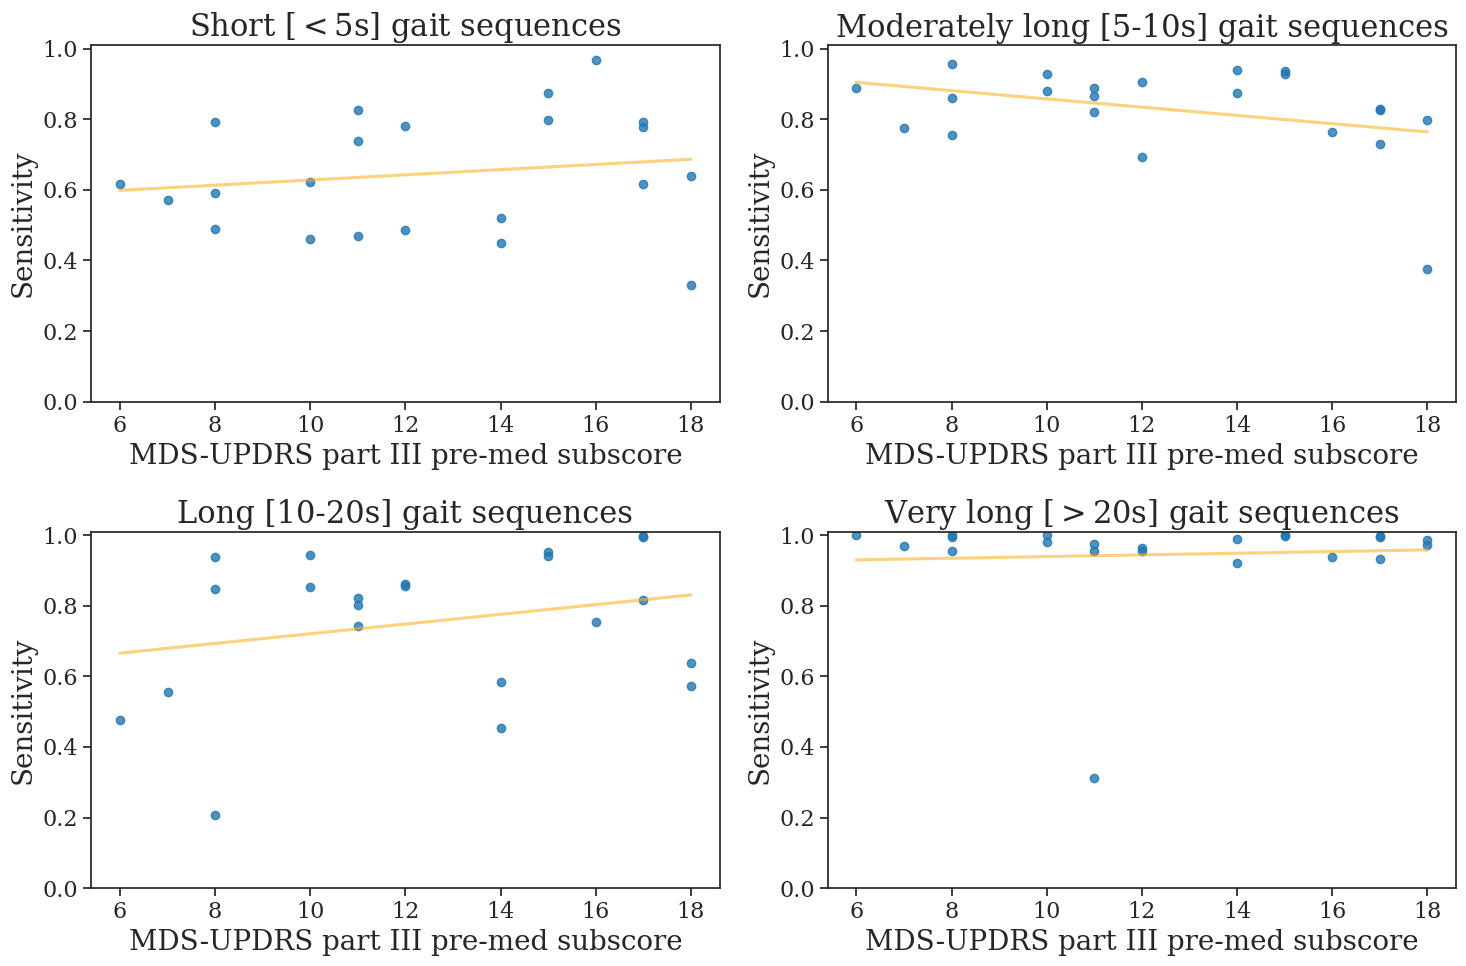

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

print("Spearman correlation between subscore and sensitivity for ...\n")
for j, seq_duration in enumerate(D_SEQUENCE_DURATIONS.keys()):
    
    df_seq_specific = df_seq_subscore.loc[df_seq_subscore['seq_duration']==seq_duration].reset_index(drop=True)

    sns.regplot(x='subscore', y='sens',
                data=df_seq_specific, ci=False, scatter_kws={'color': COLOR_PALETTE_SECOND_COLOR},
                line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PwP',
                ax=ax[j//2,j%2])

    rho = np.round(spearmanr(df_seq_specific['sens'], df_seq_specific['subscore']).correlation,2)
    rho_p = np.round(spearmanr(df_seq_specific['sens'], df_seq_specific['subscore']).pvalue,2)

    print(f"... {D_SEQUENCE_DURATIONS[seq_duration].replace('$', '')} segments: {rho} (p={rho_p})")

    ax[j//2,j%2].set_title(f'{D_SEQUENCE_DURATIONS[seq_duration]} gait sequences')
    ax[j//2,j%2].set_ylabel('Sensitivity')
    ax[j//2,j%2].set_xlabel(f'MDS-UPDRS part III pre-med subscore')
    ax[j//2,j%2].set_ylim([0,1.01])
        
fig.tight_layout()
plt.show()

Tremor

In [42]:
l_ids_tremor_pre = [x for x in d_performance[PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance['PD'][x]['rf']['MAS']['pre'].keys() and 'no_tremor_spec' in d_performance['PD'][x]['rf']['MAS']['pre'].keys()]
l_ids_tremor_post = [x for x in d_performance[PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance['PD'][x]['rf']['MAS']['post'].keys() and 'no_tremor_spec' in d_performance['PD'][x]['rf']['MAS']['post'].keys()]

d_tremor = {
    'premed_tremor': [d_performance['PD'][x]['rf']['MAS']['pre']['tremor_spec'] for x in l_ids_tremor_pre],
    'premed_nontremor': [d_performance['PD'][x]['rf']['MAS']['pre']['no_tremor_spec'] for x in l_ids_tremor_pre],
    'postmed_tremor': [d_performance['PD'][x]['rf']['MAS']['post']['tremor_spec'] for x in l_ids_tremor_post],
    'postmed_nontremor': [d_performance['PD'][x]['rf']['MAS']['post']['no_tremor_spec'] for x in l_ids_tremor_post]
}

print("Gait detection specificity during tremor vs no tremor")
print(f"P-value pre-med: {wilcoxon(d_tremor['premed_tremor'], d_tremor['premed_nontremor'])[1]}")
print(f"P-value post-med: {wilcoxon(d_tremor['postmed_tremor'], d_tremor['postmed_nontremor'])[1]}")

Gait detection specificity during tremor vs no tremor
P-value pre-med: 1.0
P-value post-med: 0.84375


In [43]:
df_tremor = pd.DataFrame()
l_tremor_bool = ['tremor', 'no_tremor']
d_pvals = {}

for med_stage in ['pre', 'post']:
    l_ids_tremor = [x for x in d_performance[PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[PARKINSONS_DISEASE][x][RANDOM_FOREST][MOST_AFFECTED_SIDE][med_stage].keys() and 'no_tremor_spec' in d_performance[PARKINSONS_DISEASE][x][RANDOM_FOREST][MOST_AFFECTED_SIDE][med_stage].keys()]

    l_specs = []
    for tremor_bool in l_tremor_bool:
        
        spec = [d_performance[PARKINSONS_DISEASE][x][RANDOM_FOREST][MOST_AFFECTED_SIDE][med_stage][f'{tremor_bool}_spec'] for x in l_ids_tremor]
        l_specs.append(spec)

        df_tremor = pd.concat([df_tremor, pd.DataFrame([
                                med_stage,
                                tremor_bool,
                                f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                ]).T], axis=0).reset_index(drop=True)
        
    p_val = wilcoxon(l_specs[0], l_specs[1])[1]

    print(f"P-value {med_stage} gait detection specificity during tremor vs no tremor: {p_val}")
    
df_tremor.columns = ['Medication stage', 'Tremor boolean', 'Specificity']

df_tremor.pivot(index='Medication stage', columns='Tremor boolean', values=['Specificity']).sort_index(ascending=False)

P-value pre gait detection specificity during tremor vs no tremor: 1.0
P-value post gait detection specificity during tremor vs no tremor: 0.84375


Specificity             
Tremor boolean      no_tremor       tremor
Medication stage                          
pre               0.93 (0.05)  0.94 (0.06)
post              0.91 (0.06)  0.89 (0.12)